In [0]:
#Priya Rajpurohit 2015073
#Sakshi Saini 2017092

In [0]:
# import tensorflow as tf
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [0]:
# import os
# try:
#     device_name = os.environ['COLAB_TPU_ADDR']
#     TPU_ADDRESS = 'grpc://' + device_name
#     print('Found TPU at: {}'.format(TPU_ADDRESS))

# except KeyError:
#     print('TPU not found')

In [0]:
import numpy as np
import cv2
from os import listdir
import tensorflow as tf
import pickle
from keras import backend as K 
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.python.keras.layers.core import Activation, Flatten, Dropout, Dense, Reshape
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing.image import img_to_array
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.python.keras.callbacks import LearningRateScheduler
import math
from tensorflow.python.keras.utils import np_utils
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
#import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

# tfds.disable_progress_bar()
#tf.enable_v2_behavior()

In [0]:
# Initialize hyperparameters.
# EPOCHS = 30
EPOCHS = 25
INIT_LR = 0.005
DECAY = 0.0005
BS = 100
default_image_size = tuple((256, 256))
resized_image_size = tuple((224,224))
image_size = 0

In [0]:
# ds, info = tfds.load("plant_village", split="train[:80%]",shuffle_files=True,
#     as_supervised=True, with_info=True)
# ds_test,info= tfds.load("plant_village", split="train[-20%:]",shuffle_files=True,
#     as_supervised=True, with_info=True)

In [0]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]

num_classes = 38

ds = tfds.load("plant_village", split=tfds.Split.TRAIN, batch_size=-1)
ds = tfds.as_numpy(ds)

images, labels = ds["image"], ds["label"]
images_new=[]
for i in range(20000):
  img=images[i]
  img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img=cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
  images_new.append(img)

# ds = tfds.load("plant_village", split='train', batch_size=-1,as_supervised=True)
# ds = tfds.as_numpy(ds)
# images, labels = ds["image"], ds["label"]
images_new=np.array(images_new)
x_train, x_test, y_train, y_test = train_test_split( images_new[:20000], labels[:20000], test_size=0.2, random_state=42 )
print(x_train.shape, x_test.shape)

# y_train = np_utils.to_categorical(y_train, num_classes)
# y_test = np_utils.to_categorical(y_test, num_classes)

(16000, 256, 256, 3) (4000, 256, 256, 3)


In [0]:
np.unique(y_train).shape
n = 38

n1 = 224
m1 = 224

x_train = np.array([cv2.resize(img, (n1,m1)) for img in x_train[:,:,:,:]])
x_test = np.array([cv2.resize(img, (n1,m1)) for img in x_test[:,:,:,:]])

# y_train = np_utils.to_categorical( y_train, n)
# y_test = np_utils.to_categorical( y_test, n)

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
   

In [0]:
# def normalize_img(image, label):
#   """Normalizes images: `uint8` -> `float32`."""
#   print(image.shape)
#   image,label=tf.cast(image, tf.float32) / 255., label
#   print(image.shape)
#   image=tf.image.resize(image, (224,224,3))
#   return image,label

# ds = ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# ds = ds.cache()
# ds = ds.shuffle(info.splits['train'].num_examples)
# ds = ds.batch(128)
# ds = ds.prefetch(tf.data.experimental.AUTOTUNE)


In [0]:
# ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# ds_test = ds_test.batch(128)
# ds_test = ds_test.cache()
# ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [0]:
# Initialize the model.
# with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
 

model = Sequential()
          
# 1st Convolutional Layer
model.add(Conv2D(filters = 96, input_shape = (224,224,3), kernel_size = (11,11), strides = (4,4), padding = 'valid'))
model.add(Activation('relu'))
# Batch Normalisation before passing it to the next layer
model.add(BatchNormalization())
# Pooling Layer
model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'valid'))

# 2nd Convolutional Layer
model.add(Conv2D(filters = 256, kernel_size = (5,5), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())
# Pooling Layer
model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'valid'))

# 3rd Convolutional Layer
model.add(Conv2D(filters = 384, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())
# Dropout
model.add(Dropout(0.5))

# 4th Convolutional Layer
model.add(Conv2D(filters = 384, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())
# Dropout
model.add(Dropout(0.5))

# 5th Convolutional Layer
model.add(Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())
# Pooling Layer
model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'valid'))
# Dropout
model.add(Dropout(0.5))

# Passing it to a dense layer
model.add(Flatten())

# 1st Dense Layer
model.add(Dense(4096, input_shape = (224*224*1,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.25))
# Batch Normalisation
model.add(BatchNormalization())

# 2nd Dense Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.5))
# Batch Normalisation
model.add(BatchNormalization())

# 3rd Dense Layer
model.add(Dense(1000))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.5))
# Batch Normalisation
model.add(BatchNormalization())

# Output Layer
model.add(Dense(38))
model.add(Activation('softmax'))

# Get the model summary.
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 54, 54, 96)        34944     
_________________________________________________________________
activation_9 (Activation)    (None, 54, 54, 96)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 54, 54, 96)        384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 26, 26, 256)       614656    
_________________________________________________________________
activation_10 (Activation)   (None, 26, 26, 256)       0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 26, 26, 256)      

In [0]:
# Initialize hyperparameters.
EPOCHS = 30
INIT_LR = 0.005
DECAY = 0.0005
BS = 100
default_image_size = tuple((256, 256))
resized_image_size = tuple((224,224))

In [0]:
# aug = ImageDataGenerator(
#     rotation_range = 20,
#     width_shift_range = 0.2,
#     height_shift_range = 0.2,
#     shear_range = 0.2, 
#     zoom_range = 0.2,
#     horizontal_flip = True, 
#     fill_mode = "nearest")

# aug.fit(x_train)

In [0]:
def decay(epoch, steps=100):
    initial_lrate = 0.005
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
lr_sc = LearningRateScheduler(decay)
opt = tf.keras.optimizers.SGD(lr=INIT_LR, momentum=0.9, nesterov=False)
model.compile(loss="categorical_crossentropy", optimizer = opt,metrics = ["accuracy"])

In [0]:
print(y_train.shape,x_train.shape)
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
print(y_train.shape)
y_test.shape#

(16000,) (16000, 224, 224, 3)
(16000, 38)


(4000, 38)

In [0]:

history = model.fit(
   x_train, y_train,
    validation_data = (x_test,y_test),
    batch_size=BS,
    callbacks = [lr_sc],
    epochs = EPOCHS )

# tpu_model = tf.contrib.tpu.keras_to_tpu_model(
#     model,
#     strategy=tf.contrib.tpu.TPUDistributionStrategy(
#         tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)))
# tpu_model.fit(
#     train_input_fn,
#     steps_per_epoch = 60,
#     epochs=10,
# )

Epoch 1/30
160/160 [==============================] - 214s 1s/step - loss: 3.2639 - accuracy: 0.2102 - val_loss: 3.5619 - val_accuracy: 0.2247 - lr: 0.0050
Epoch 2/30
160/160 [==============================] - 215s 1s/step - loss: 2.3631 - accuracy: 0.3647 - val_loss: 3.9752 - val_accuracy: 0.1460 - lr: 0.0050
Epoch 3/30
160/160 [==============================] - 213s 1s/step - loss: 1.9629 - accuracy: 0.4489 - val_loss: 37.4639 - val_accuracy: 0.0955 - lr: 0.0050
Epoch 4/30
160/160 [==============================] - 213s 1s/step - loss: 1.6510 - accuracy: 0.5203 - val_loss: 10.6438 - val_accuracy: 0.1423 - lr: 0.0050
Epoch 5/30
160/160 [==============================] - 212s 1s/step - loss: 1.4100 - accuracy: 0.5791 - val_loss: 1.7207 - val_accuracy: 0.5170 - lr: 0.0050
Epoch 6/30
160/160 [==============================] - 213s 1s/step - loss: 1.2164 - accuracy: 0.6297 - val_loss: 2.6288 - val_accuracy: 0.3957 - lr: 0.0050
Epoch 7/30
160/160 [==============================] - 213s 1s/

In [0]:
!mkdir -p saved_model
#tpu_model.save('saved_model/AlexNet') 
model.save('saved_model/AlexNet_gray') 

INFO:tensorflow:Assets written to: saved_model/AlexNet_gray/assets


INFO:tensorflow:Assets written to: saved_model/AlexNet_gray/assets


In [0]:

!zip -r AlexNet_gray.zip saved_model/AlexNet_gray/
#Download files
from google.colab import files
files.download('AlexNet_gray.zip')

updating: saved_model/AlexNet_gray/ (stored 0%)
updating: saved_model/AlexNet_gray/saved_model.pb (deflated 91%)
updating: saved_model/AlexNet_gray/variables/ (stored 0%)
updating: saved_model/AlexNet_gray/variables/variables.data-00000-of-00001 (deflated 8%)
updating: saved_model/AlexNet_gray/variables/variables.index (deflated 75%)
updating: saved_model/AlexNet_gray/assets/ (stored 0%)


In [0]:
final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

FINAL ACCURACY MEAN-5:  0.5430499970912933


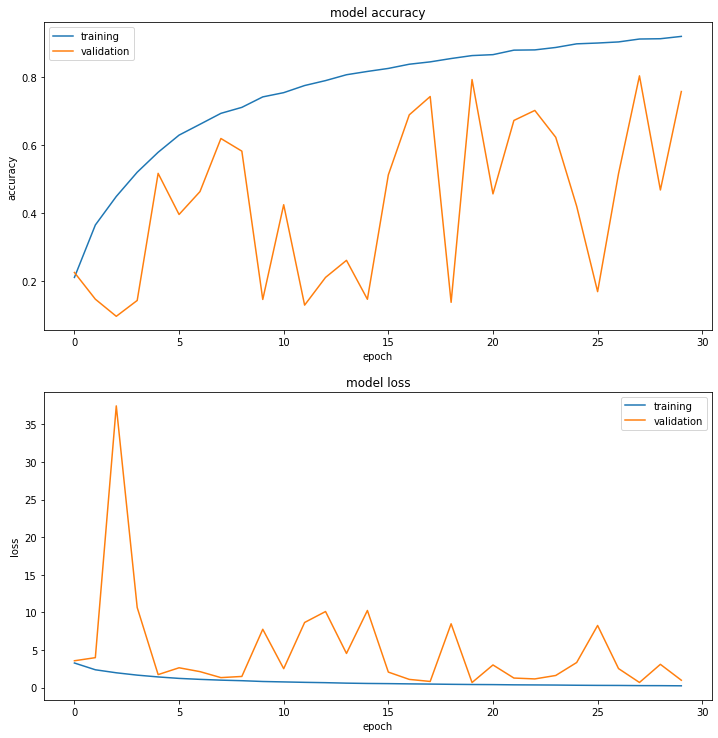

In [0]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)